In [245]:
import pandas as pd
import sklearn as sk
from sklearn.preprocessing import StandardScaler
import seaborn as sns
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split
import torch
import torch.optim as optim
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt
import plotly.express

# Part 1
Data loading and Preprocessing

In [246]:
datset = pd.read_csv('dataset.csv')
datset = datset.astype(str)
col = datset.columns
datset = datset[~datset.apply(lambda x: x.str.contains('[a-zA-Z]')).any(axis=1)]
for i in col:
    datset[i] = pd.to_numeric(datset[i])
datset = datset.dropna()
print(datset.describe())
print(datset.shape)
y = datset[col[-1]]
X = datset.drop(col[-1],axis=1)
scaler = StandardScaler()
model = scaler.fit(X)
X_scaled_data = model.transform(X)
X_scaled_df = pd.DataFrame(X_scaled_data,columns=col[0:7])
print(X_scaled_df.describe())
X_train, X_test,y_train, y_test = train_test_split(X_scaled_df, y, random_state=104, test_size=0.4, shuffle=True)
X_val, X_test,y_val, y_test = train_test_split(X_test, y_test, random_state=104, test_size=0.5, shuffle=True)
  

               f1          f2          f3          f4          f5          f6  \
count  760.000000  760.000000  760.000000  760.000000  760.000000  760.000000   
mean     3.834211  120.969737   69.119737   20.507895   80.234211   31.998684   
std      3.364762   32.023301   19.446088   15.958029  115.581444    7.899724   
min      0.000000    0.000000    0.000000    0.000000    0.000000    0.000000   
25%      1.000000   99.000000   63.500000    0.000000    0.000000   27.300000   
50%      3.000000  117.000000   72.000000   23.000000   36.000000   32.000000   
75%      6.000000  141.000000   80.000000   32.000000  128.250000   36.600000   
max     17.000000  199.000000  122.000000   99.000000  846.000000   67.100000   

               f7      target  
count  760.000000  760.000000  
mean     0.473250    0.350000  
std      0.332277    0.477284  
min      0.078000    0.000000  
25%      0.243750    0.000000  
50%      0.375500    0.000000  
75%      0.627500    1.000000  
max      2.420

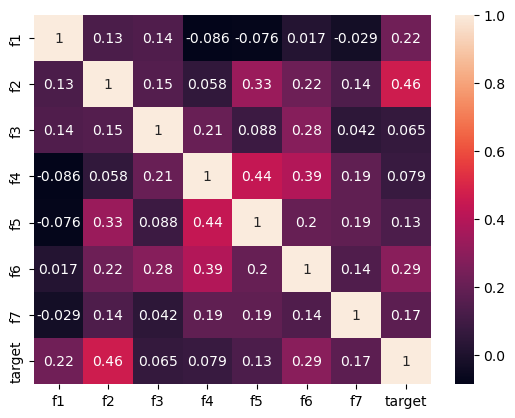

In [86]:
corr_matrix = datset.corr()
sns.heatmap(corr_matrix, annot = True)
plt.show()

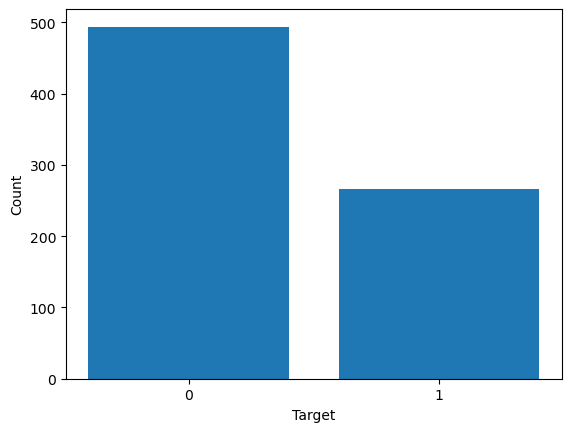

In [262]:
count_list = datset['target'].value_counts()
plt.bar(['0','1'], count_list)
plt.xlabel('Target')
plt.ylabel('Count')
plt.show()

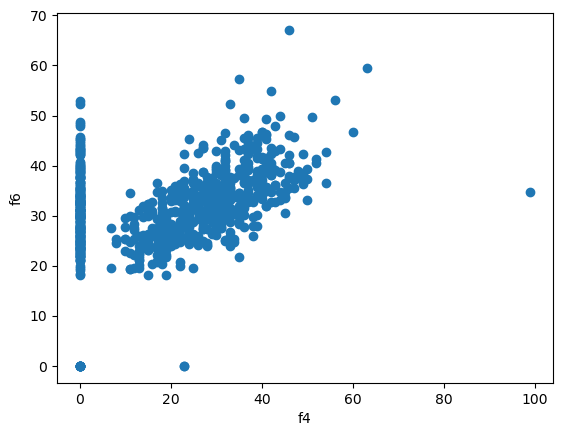

In [89]:
plt.scatter(datset['f4'], datset['f6'])
plt.xlabel('f4')
plt.ylabel('f6')
plt.show()

Model Creation

In [90]:
class NeuralNetwork(nn.Module):
    def __init__(self):
        super(NeuralNetwork, self).__init__()
        self.fc1 = nn.Linear(input_size, 128)
        self.fc2 = nn.Linear(128, 64)
        self.fc3 = nn.Linear(64, output_size)
        self.relu = nn.ReLU()
        # self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        x = self.fc1(x)
        x = self.relu(x)
        x = self.fc2(x)
        x = self.relu(x)
        x = self.fc3(x)
        # x = self.sigmoid(x)
        return x

Model Train

In [105]:
def model_train(model, X_train, y_train, epochs = 10, batch_size = 64, criterion = nn.BCEWithLogitsLoss(), optimizer = None):
    model = model
    if optimizer == None:
        optimizer = optim.SGD(model.parameters(), lr=0.01)
    run_loss = []
    run_acc = []
    for epoch in range(epochs):
        running_loss = 0.0
        for i in range(0, len(X_train), batch_size):
            # Get the inputs and labels for this batch
            inputs = torch.FloatTensor(X_train[i:i+batch_size].values)
            labels = torch.FloatTensor(y_train[i:i+batch_size].values.reshape(-1, 1))

            # Zero the parameter gradients
            optimizer.zero_grad()

            # Forward + backward + optimize
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            # Print statistics
            running_loss += loss.item()
        run_loss.append(running_loss / len(X_train))
        with torch.no_grad():
            inputs = torch.FloatTensor(X_test.values)
            labels = torch.FloatTensor(y_test.values.reshape(-1, 1))
            outputs = model(inputs)
            predictions = (outputs > 0).float()
            accuracy = (predictions == labels).float().mean()
            run_acc.append(accuracy)
        if epoch%10 == 9: 
            print('Epoch %d loss: %.3f' % (epoch + 1, running_loss / len(X)))
            print('Validation accuracy: %.3f' %accuracy)
    return (run_loss,run_acc)

In [106]:
input_size = X_train.shape[1]
output_size = 1
model_base = NeuralNetwork()
optimizer = optim.SGD(model_base.parameters(), lr=0.01)
list_loss,list_acc = model_train(model_base,X_train,y_train,epochs=100, optimizer=optimizer)

Epoch 10 loss: 0.007
Validation accuracy: 0.678
Epoch 20 loss: 0.006
Validation accuracy: 0.658
Epoch 30 loss: 0.006
Validation accuracy: 0.678
Epoch 40 loss: 0.006
Validation accuracy: 0.691
Epoch 50 loss: 0.005
Validation accuracy: 0.737
Epoch 60 loss: 0.005
Validation accuracy: 0.776
Epoch 70 loss: 0.005
Validation accuracy: 0.783
Epoch 80 loss: 0.005
Validation accuracy: 0.776
Epoch 90 loss: 0.005
Validation accuracy: 0.783
Epoch 100 loss: 0.005
Validation accuracy: 0.789


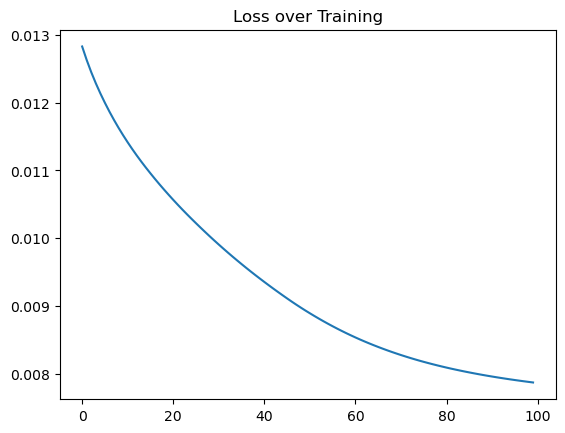

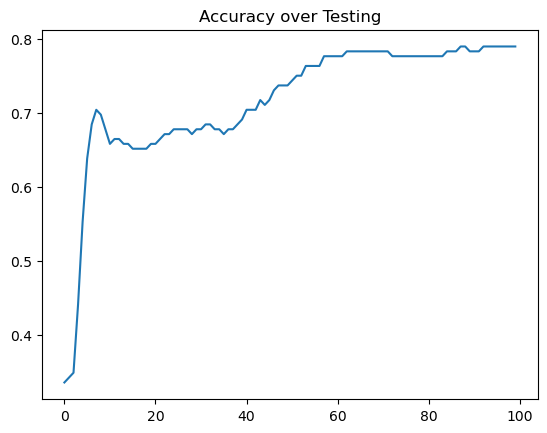

In [244]:
plt.plot(list_loss)
plt.title('Loss over Training')
plt.show()
plt.plot(list_acc)
plt.title('Accuracy over Testing')
plt.show()

Model Validation

In [108]:
def model_vald(model,X, y):
    with torch.no_grad():
        inputs = torch.FloatTensor(X.values)
        labels = torch.FloatTensor(y.values.reshape(-1, 1))
        outputs = model(inputs)
        predictions = (outputs > 0).float()
        accuracy = (predictions == labels).float().mean()
        print('Validation accuracy: %.3f' %accuracy)
    return predictions

In [109]:
model_pred = model_vald(model_base,X_test,y_test)
torch.save(model_base.state_dict(), 'Jagruth_Vachan_Assigment2_Part1.h5')

Validation accuracy: 0.789


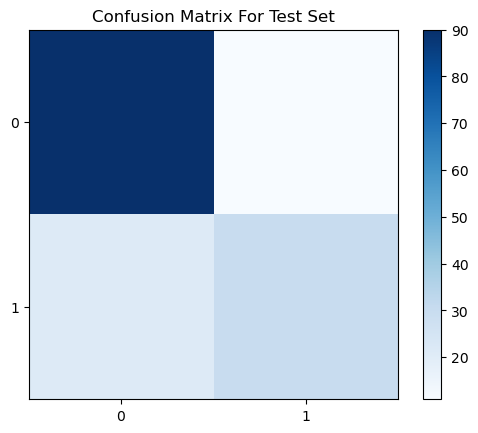

In [110]:
confusion_mat = confusion_matrix(y_test, model_pred)
plt.imshow(confusion_mat, interpolation = 'nearest', cmap = plt.cm.Blues)
plt.colorbar()
plt.title('Confusion Matrix For Test Set')
plt.xticks([0, 1], ['0', '1'])
plt.yticks([0, 1], ['0', '1'])
plt.show()

Validation accuracy: 0.783


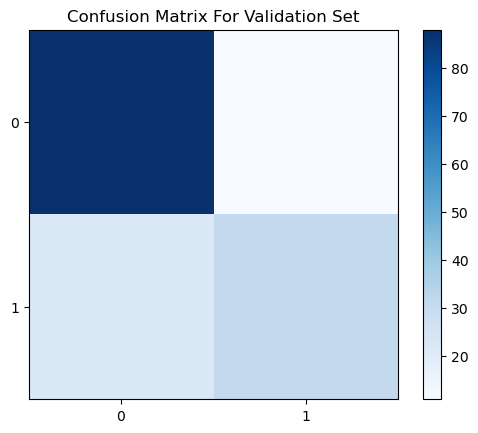

In [111]:
model_val_pred = model_vald(model_base,X_val,y_val)
confusion_mat_val = confusion_matrix(y_val, model_val_pred)
plt.imshow(confusion_mat_val, interpolation = 'nearest', cmap = plt.cm.Blues)
plt.colorbar()
plt.title('Confusion Matrix For Validation Set')
plt.xticks([0, 1], ['0', '1'])
plt.yticks([0, 1], ['0', '1'])
plt.show()

# Part 2

Editing the model, train and test functions to accomidate changing hyperparameters

In [174]:
def train_and_evaluate(dropout, optimizer, activation_function, initializer):
    
    class NeuralNetwork(nn.Module):
        def __init__(self, dropout, activation_function, initializer):
            super(NeuralNetwork, self).__init__()
            self.fc1 = nn.Linear(input_size, 128)
            initializer(self.fc1.weight)
            self.dropout1 = nn.Dropout(dropout)
            self.fc2 = nn.Linear(128, 64)
            initializer(self.fc2.weight)
            self.dropout2 = nn.Dropout(dropout)
            self.fc3 = nn.Linear(64, output_size)
            initializer(self.fc3.weight)
            self.activation_function = activation_function

        def forward(self, x):
            x = self.fc1(x)
            x = self.activation_function(x)
            x = self.dropout1(x)
            x = self.fc2(x)
            x = self.activation_function(x)
            x = self.dropout2(x)
            x = self.fc3(x)
            return x

    model = NeuralNetwork(dropout = dropout, activation_function = activation_function, initializer = initializer)

    criterion = nn.BCEWithLogitsLoss()
    optimizer = optimizer(model.parameters(), lr = 0.01)

    epochs = 100
    batch_size = 64
    list_accuracy = []
    list_loss = []
    for epoch in range(epochs):
        running_loss = 0.0
        for i in range(0, len(X_train), batch_size):
            inputs = torch.FloatTensor(X_train[i:i+batch_size].values)
            labels = torch.FloatTensor(y_train[i:i+batch_size].values.reshape(-1, 1))

            optimizer.zero_grad()

            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            predictions = (outputs > 0).float()
            running_loss += (predictions == labels).float().sum()
        list_loss.append(running_loss/len(X_train))
        with torch.no_grad():
            inputs_values = torch.FloatTensor(X_test.values)
            labels_values = torch.FloatTensor(y_test.values.reshape(-1, 1))
            outputs_values = model(inputs_values)
            predictions_values = (outputs_values > 0).float()
            accuracy_values = (predictions_values == labels_values).float().mean()
            list_accuracy.append(accuracy_values)

    return (accuracy_values,list_accuracy,list_loss,model)

Dropout Hyperparameter

In [178]:
accuracy_values1,list_accuracy1,list_loss1,model1 = train_and_evaluate(dropout = 0.1, optimizer = optim.SGD, activation_function = nn.ReLU(), initializer = nn.init.xavier_normal_)
accuracy_values2,list_accuracy2,list_loss2,model2 = train_and_evaluate(dropout = 0.2, optimizer = optim.SGD, activation_function = nn.ReLU(), initializer = nn.init.xavier_normal_)
accuracy_values3,list_accuracy3,list_loss3,model3 = train_and_evaluate(dropout = 0.3, optimizer = optim.SGD, activation_function = nn.ReLU(), initializer = nn.init.xavier_normal_)
print(accuracy_values1,accuracy_values2,accuracy_values3)

tensor(0.7763) tensor(0.7763) tensor(0.7303)


Optimizer Hyperparameter

In [179]:
accuracy_values4,list_accuracy4,list_loss4,model4 = train_and_evaluate(dropout = 0.1, optimizer = optim.Adam, activation_function = nn.ReLU(), initializer = nn.init.xavier_normal_)
accuracy_values5,list_accuracy5,list_loss5,model5 = train_and_evaluate(dropout = 0.1, optimizer = optim.RMSprop, activation_function = nn.ReLU(), initializer = nn.init.xavier_normal_)
accuracy_values6,list_accuracy6,list_loss6,model6 = train_and_evaluate(dropout = 0.1, optimizer = optim.Adagrad, activation_function = nn.ReLU(), initializer = nn.init.xavier_normal_)
print(accuracy_values4,accuracy_values5,accuracy_values6)

tensor(0.7039) tensor(0.6711) tensor(0.7368)


Activation Function Hyperparameter

In [181]:
accuracy_values7,list_accuracy7,list_loss7,model7 = train_and_evaluate(dropout = 0.1, optimizer = optim.SGD, activation_function = nn.LeakyReLU(0.2), initializer = nn.init.xavier_normal_)
accuracy_values8,list_accuracy8,list_loss8,model8 = train_and_evaluate(dropout = 0.1, optimizer = optim.SGD, activation_function = nn.Sigmoid(), initializer = nn.init.xavier_normal_)
accuracy_values9,list_accuracy9,list_loss9,model9 = train_and_evaluate(dropout = 0.1, optimizer = optim.SGD, activation_function = nn.Tanh(), initializer = nn.init.xavier_normal_)
print(accuracy_values7,accuracy_values8,accuracy_values9)

tensor(0.7961) tensor(0.6645) tensor(0.7829)


Initializer Hyperparameter

In [182]:
accuracy_values10,list_accuracy10,list_loss10,model10 = train_and_evaluate(dropout = 0.1, optimizer = optim.SGD, activation_function = nn.LeakyReLU(0.2), initializer = nn.init.uniform_)
accuracy_values11,list_accuracy11,list_loss11,model11 = train_and_evaluate(dropout = 0.1, optimizer = optim.SGD, activation_function = nn.LeakyReLU(0.2), initializer = nn.init.normal_)
accuracy_values12,list_accuracy12,list_loss12,model12 = train_and_evaluate(dropout = 0.1, optimizer = optim.SGD, activation_function = nn.LeakyReLU(0.2), initializer = nn.init.ones_)
print(accuracy_values10,accuracy_values11,accuracy_values12)

tensor(0.7237) tensor(0.6645) tensor(0.6908)


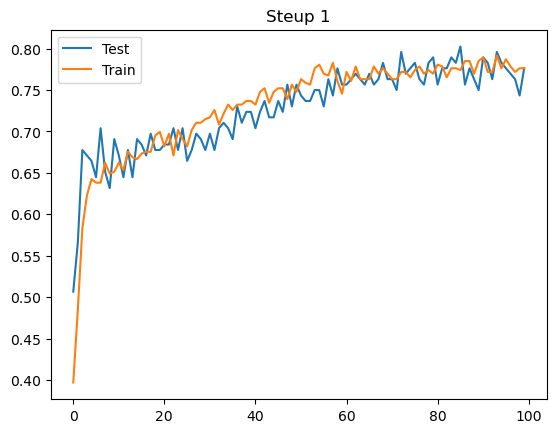

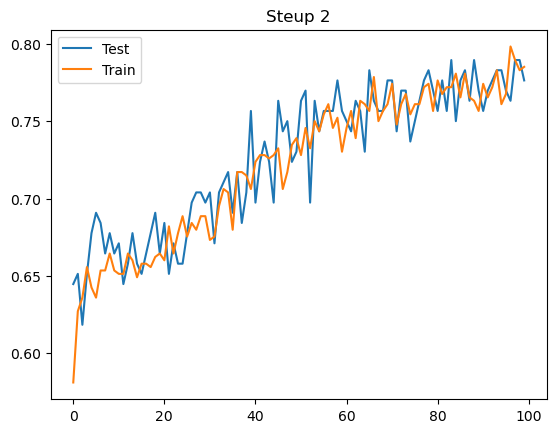

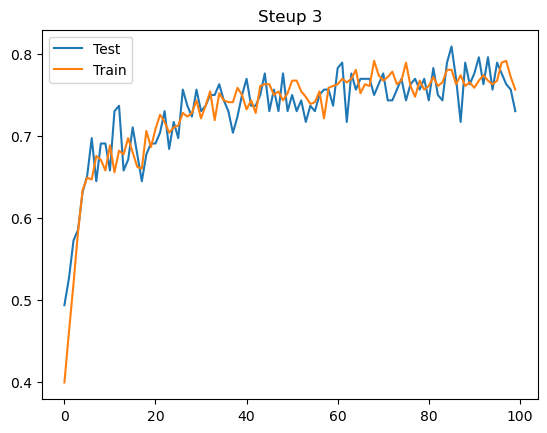

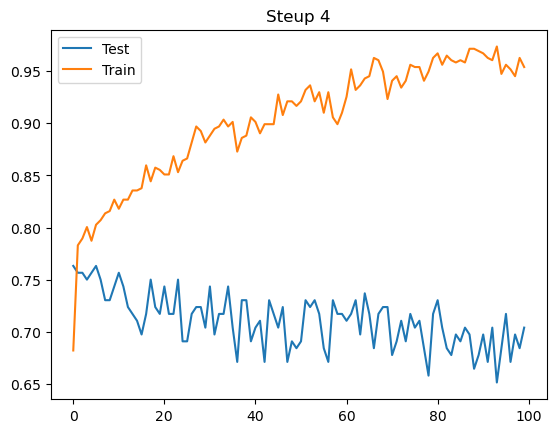

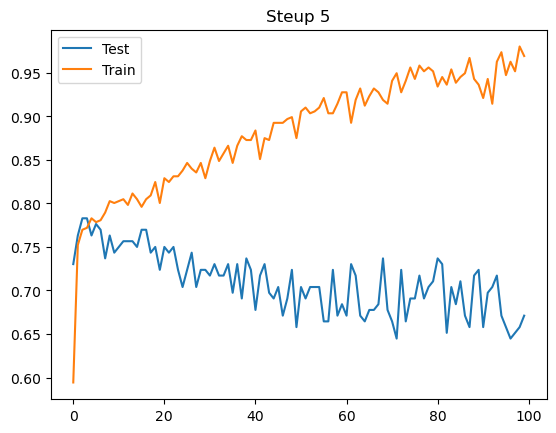

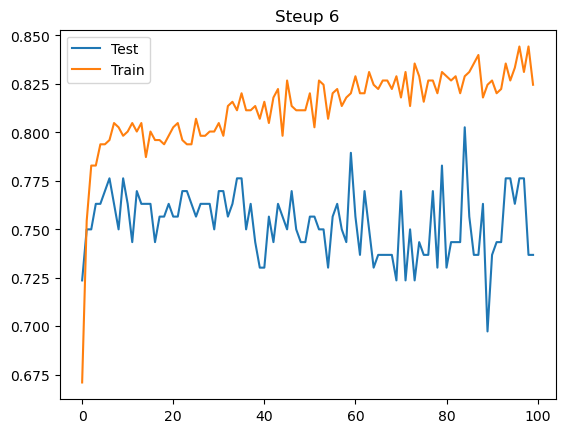

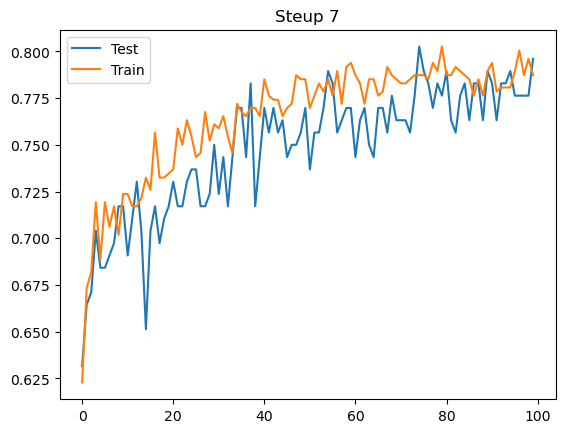

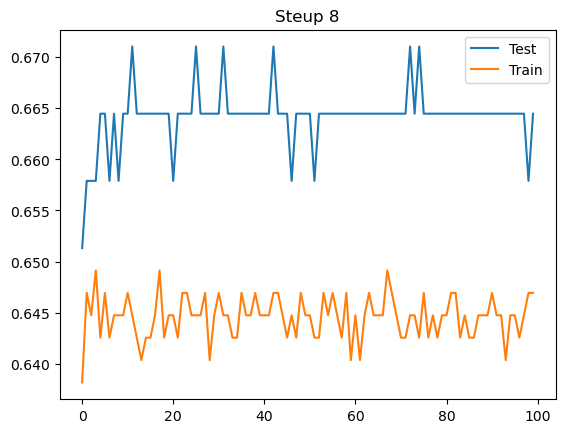

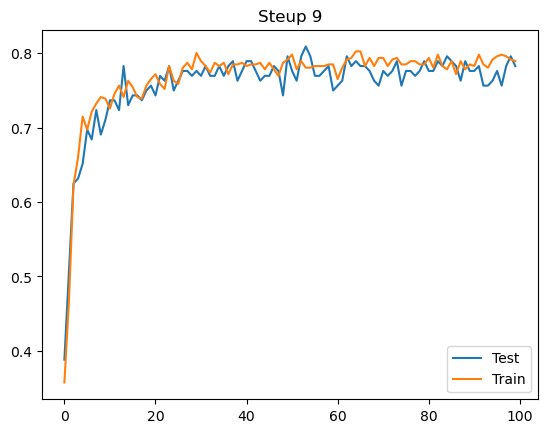

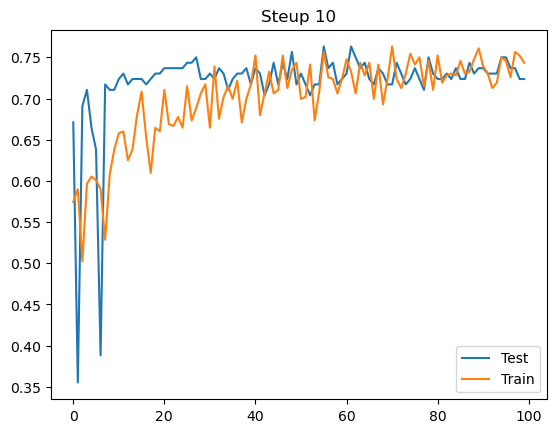

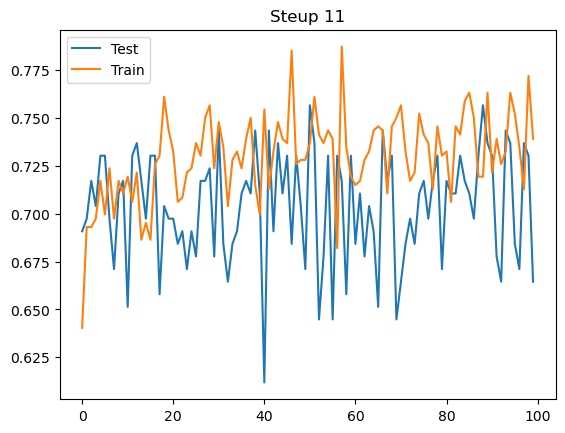

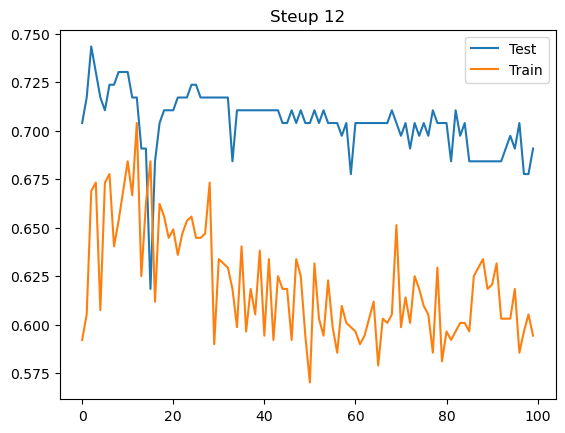

In [263]:
plt.plot(list_accuracy1,label='Test')
plt.plot(list_loss1,label='Train')
plt.legend()
plt.title('Steup 1')
plt.show()
plt.plot(list_accuracy2,label='Test')
plt.plot(list_loss2,label='Train')
plt.legend()
plt.title('Steup 2')
plt.show()
plt.plot(list_accuracy3,label='Test')
plt.plot(list_loss3,label='Train')
plt.legend()
plt.title('Steup 3')
plt.show()
plt.plot(list_accuracy4,label='Test')
plt.plot(list_loss4,label='Train')
plt.legend()
plt.title('Steup 4')
plt.show()
plt.plot(list_accuracy5,label='Test')
plt.plot(list_loss5,label='Train')
plt.legend()
plt.title('Steup 5')
plt.show()
plt.plot(list_accuracy6,label='Test')
plt.plot(list_loss6,label='Train')
plt.legend()
plt.title('Steup 6')
plt.show()
plt.plot(list_accuracy7,label='Test')
plt.plot(list_loss7,label='Train')
plt.legend()
plt.title('Steup 7')
plt.show()
plt.plot(list_accuracy8,label='Test')
plt.plot(list_loss8,label='Train')
plt.legend()
plt.title('Steup 8')
plt.show()
plt.plot(list_accuracy9,label='Test')
plt.plot(list_loss9,label='Train')
plt.legend()
plt.title('Steup 9')
plt.show()
plt.plot(list_accuracy10,label='Test')
plt.plot(list_loss10,label='Train')
plt.legend()
plt.title('Steup 10')
plt.show()
plt.plot(list_accuracy11,label='Test')
plt.plot(list_loss11,label='Train')
plt.legend()
plt.title('Steup 11')
plt.show()
plt.plot(list_accuracy12,label='Test')
plt.plot(list_loss12,label='Train')
plt.legend()
plt.title('Steup 12')
plt.show()

Best model

In [213]:
model7
accuracy_values7

tensor(0.7961)

Learning Rate Scheduler

In [196]:
class NeuralNetwork(nn.Module):
    def __init__(self, dropout, activation_function, initializer):
        super(NeuralNetwork, self).__init__()
        self.fc1 = nn.Linear(input_size, 128)
        initializer(self.fc1.weight)
        self.dropout1 = nn.Dropout(dropout)
        self.fc2 = nn.Linear(128, 64)
        initializer(self.fc2.weight)
        self.dropout2 = nn.Dropout(dropout)
        self.fc3 = nn.Linear(64, output_size)
        initializer(self.fc3.weight)
        self.activation_function = activation_function

    def forward(self, x):
        x = self.fc1(x)
        x = self.activation_function(x)
        x = self.dropout1(x)
        x = self.fc2(x)
        x = self.activation_function(x)
        x = self.dropout2(x)
        x = self.fc3(x)
        return x

lrsch_accuracy = []
model_lrsch=NeuralNetwork(dropout = 0.1, activation_function = nn.LeakyReLU(0.2), initializer = nn.init.xavier_normal_)
criterion=nn.CrossEntropyLoss()
batch_size=64
num_epochs=100
learning_rate=0.1
optimizer=optim.SGD(model_lrsch.parameters(), lr=learning_rate)
scheduler=optim.lr_scheduler.StepLR(optimizer, step_size = 10, gamma=0.1)
for epoch in range(num_epochs):
    for i in range(0, len(X_train), batch_size):
        inputs = torch.FloatTensor(X_train[i:i+batch_size].values)
        labels = torch.FloatTensor(y_train[i:i+batch_size].values.reshape(-1, 1))
        optimizer.zero_grad()
        outputs = model_lrsch(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
    scheduler.step()
    if epoch%10 == 9:
        print('Epoch', epoch+1,'/',num_epochs,'LR',optimizer.param_groups[0]['lr'])      

    with torch.no_grad():
        inputs_values = torch.FloatTensor(X_test.values)
        labels_values = torch.FloatTensor(y_test.values.reshape(-1, 1))
        outputs_values=model_lrsch(inputs_values)
        predictions_values = (outputs_values > 0).float()
        accuracy_values = (predictions_values == labels_values).float().mean()
        lrsch_accuracy.append(accuracy_values)
print('Accuracy of the testing data:', accuracy_values)


Epoch 10 / 100 LR 0.010000000000000002
Epoch 20 / 100 LR 0.0010000000000000002
Epoch 30 / 100 LR 0.00010000000000000003
Epoch 40 / 100 LR 1.0000000000000004e-05
Epoch 50 / 100 LR 1.0000000000000004e-06
Epoch 60 / 100 LR 1.0000000000000005e-07
Epoch 70 / 100 LR 1.0000000000000005e-08
Epoch 80 / 100 LR 1.0000000000000005e-09
Epoch 90 / 100 LR 1.0000000000000006e-10
Epoch 100 / 100 LR 1.0000000000000006e-11
Accuracy of the testing data: tensor(0.5987)


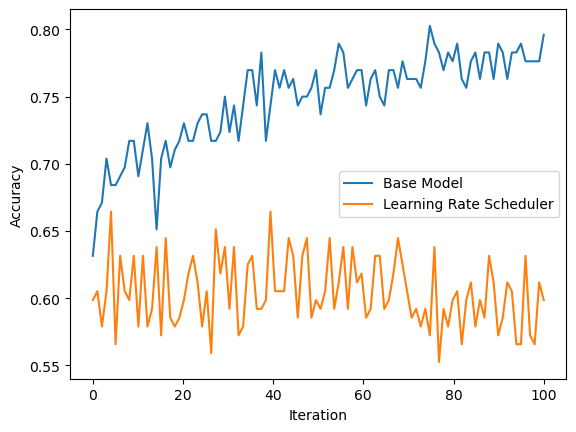

In [197]:
x1 = np.linspace(0, 100, len(list_accuracy7))
y1 = list_accuracy7
x2 = np.linspace(0, 100, len(lrsch_accuracy))
y2 = lrsch_accuracy

# Plot the lines with different sizes
plt.plot(x1, y1, label = 'Base Model')
plt.plot(x2, y2, label = 'Learning Rate Scheduler')

# Add title, labels and legend
plt.xlabel('Iteration')
plt.ylabel('Accuracy')
plt.legend()

# Show the plot
plt.show()

Gradient Clipping

In [231]:
model_gc = NeuralNetwork(dropout = 0.1, activation_function = nn.LeakyReLU(0.2), initializer = nn.init.xavier_normal_)
clip_value = 1
criterion = nn.BCEWithLogitsLoss()
grad_accuracy = []
optimizer=optim.SGD(model_gc.parameters(), lr=0.01)
def clip_gradient_norm(parameters):
    parameters = list(filter(lambda p: p.grad is not None, parameters))
    total_norm = torch.norm(torch.stack([torch.norm(p.grad.detach()) for p in parameters]))
    clip_coef = clip_value / (total_norm + 1e-6)
    
    if clip_coef < 1:
        for p in parameters:
            p.grad.detach().mul_(clip_coef)
    return total_norm
    
epochs = 100
batch_size = 64
for epoch in range(epochs):
    for i in range(0, len(X_train), batch_size):
        
        inputs = torch.FloatTensor(X_train[i:i+batch_size].values)
        labels = torch.FloatTensor(y_train[i:i+batch_size].values.reshape(-1, 1))

        optimizer.zero_grad()

        outputs = model_gc(inputs)
        loss = criterion(outputs, labels)
        loss.backward()

        # Apply gradient clipping if provided
        clip_gradient_norm(model_gc.parameters())
        optimizer.step()

    with torch.no_grad():
        inputs_val = torch.FloatTensor(X_test.values)
        labels_val = torch.FloatTensor(y_test.values.reshape(-1, 1))
        outputs_val = model_gc(inputs_val)
        predictions_val = (outputs_val > 0).float()
        accuracy_val = (predictions_val == labels_val).float().mean()
        grad_accuracy.append(accuracy_val)
        
print('Accuracy of the testing data:', grad_accuracy[-1])

Accuracy of the testing data: tensor(0.7829)


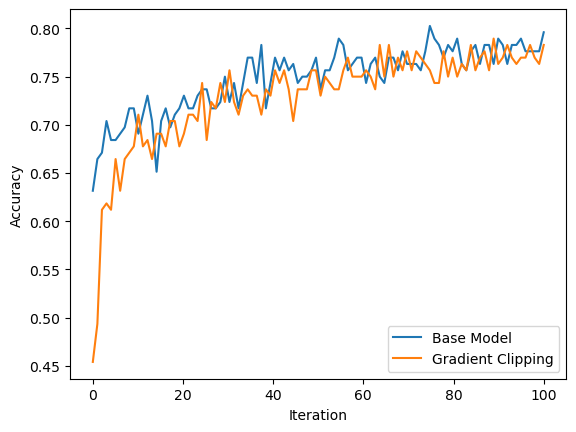

In [232]:
x1 = np.linspace(0, 100, len(list_accuracy7))
y1 = list_accuracy7
x2 = np.linspace(0, 100, len(grad_accuracy))
y2 = grad_accuracy

# Plot the lines with different sizes
plt.plot(x1, y1, label = 'Base Model')
plt.plot(x2, y2, label = 'Gradient Clipping')

# Add title, labels and legend
plt.xlabel('Iteration')
plt.ylabel('Accuracy')
plt.legend()

# Show the plot
plt.show()

K-Fold

In [236]:
model_kf = NeuralNetwork(dropout = 0.1, activation_function = nn.LeakyReLU(0.2), initializer = nn.init.xavier_normal_)
criterion = nn.BCEWithLogitsLoss()
kfold_accuracy = []
optimizer=optim.SGD(model_kf.parameters(), lr=0.01)

    
epochs = 100
batch_size = 128
for epoch in range(epochs):
    for i in range(0, len(X_train), batch_size):
        
        inputs = torch.FloatTensor(X_train[i:i+batch_size].values)
        labels = torch.FloatTensor(y_train[i:i+batch_size].values.reshape(-1, 1))

        optimizer.zero_grad()

        outputs = model_kf(inputs)
        loss = criterion(outputs, labels)
        loss.backward()

        # Apply gradient clipping if provided
        #clip_gradient_norm(model_kf.parameters())
        optimizer.step()

    with torch.no_grad():
        inputs_val = torch.FloatTensor(X_test.values)
        labels_val = torch.FloatTensor(y_test.values.reshape(-1, 1))
        outputs_val = model_kf(inputs_val)
        predictions_val = (outputs_val > 0).float()
        accuracy_val = (predictions_val == labels_val).float().mean()
        kfold_accuracy.append(accuracy_val)
        
print('Accuracy of the testing data:', kfold_accuracy[-1])

Accuracy of the testing data: tensor(0.8026)


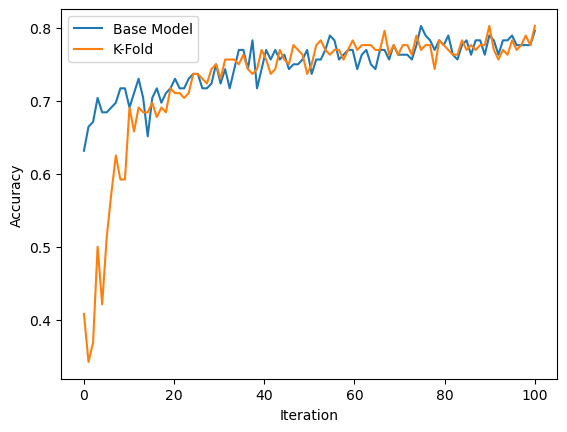

In [237]:
x1 = np.linspace(0, 100, len(list_accuracy7))
y1 = list_accuracy7
x2 = np.linspace(0, 100, len(kfold_accuracy))
y2 = kfold_accuracy

# Plot the lines with different sizes
plt.plot(x1, y1, label = 'Base Model')
plt.plot(x2, y2, label = 'K-Fold')

# Add title, labels and legend
plt.xlabel('Iteration')
plt.ylabel('Accuracy')
plt.legend()

# Show the plot
plt.show()

Early Stopping

In [238]:
model_es = NeuralNetwork(dropout = 0.1, activation_function = nn.LeakyReLU(0.2), initializer = nn.init.xavier_normal_)
earlystop_accuracy = []
criterion = nn.BCEWithLogitsLoss()
optimizer = optim.SGD(model_es.parameters(), lr = 0.01)

epochs = 100
batch_size = 64
best_val_loss = 1
epochs_without_improvement = 0
for epoch in range(epochs):
    for i in range(0, len(X_train), batch_size):
        
        inputs = torch.FloatTensor(X_train[i:i+batch_size].values)
        labels = torch.FloatTensor(y_train[i:i+batch_size].values.reshape(-1, 1))

        optimizer.zero_grad()

        outputs = model_es(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
    
    with torch.no_grad():
        inputs_value = torch.FloatTensor(X_test.values)
        labels_value = torch.FloatTensor(y_test.values.reshape(-1, 1))
        outputs_value = model_es(inputs_value)
        loss_value = criterion(outputs_value, labels_value)
        if loss_value < best_val_loss:
            best_val_loss = loss_value
            epochs_without_improvement = 0
        else:
            epochs_without_improvement += 1
            if epochs_without_improvement >= 5:         # Early stopping if validation loss does not improve.
                print("Validation loss did not improve for 5 epochs. Stopping early.")
                break
        predictions_value = (outputs_value > 0).float()
        accuracy_value = (predictions_value == labels_value).float().mean()
        earlystop_accuracy.append(accuracy_value)
        
print('Accuracy of the testing data:', earlystop_accuracy[-1])

Validation loss did not improve for 5 epochs. Stopping early.
Accuracy of the testing data: tensor(0.7303)


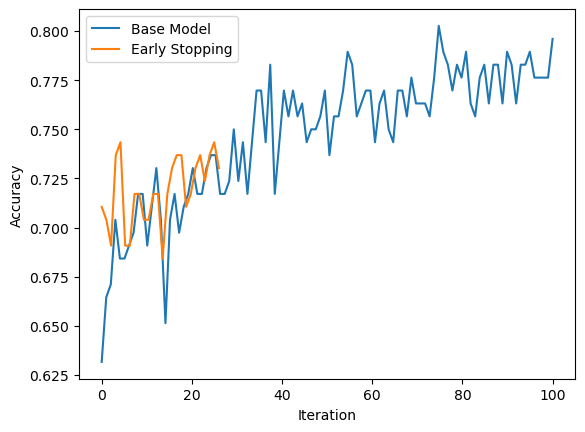

In [239]:
x1 = np.linspace(0, 100, len(list_accuracy7))
y1 = list_accuracy7
x2 = np.linspace(0, len(earlystop_accuracy), len(earlystop_accuracy))
y2 = earlystop_accuracy

# Plot the lines with different sizes
plt.plot(x1, y1, label = 'Base Model')
plt.plot(x2, y2, label = 'Early Stopping')

# Add title, labels and legend
plt.xlabel('Iteration')
plt.ylabel('Accuracy')
plt.legend()

# Show the plot
plt.show()

In [240]:
torch.save(model_kf.state_dict(), 'Jagruth_Vachan_Assigment2_Part2.h5')

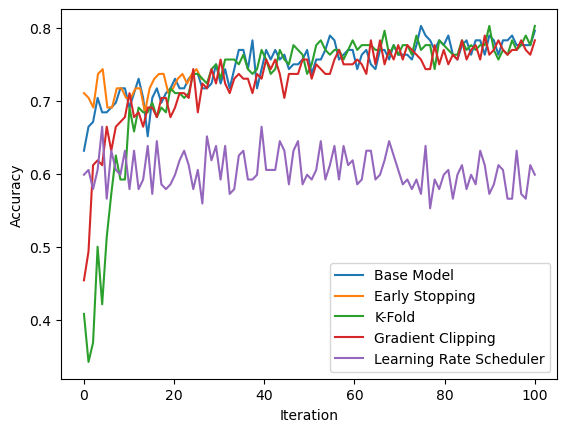

In [241]:
x1 = np.linspace(0, 100, len(list_accuracy7))
y1 = list_accuracy7
x2 = np.linspace(0, len(earlystop_accuracy), len(earlystop_accuracy))
y2 = earlystop_accuracy
x3 = np.linspace(0, 100, len(kfold_accuracy))
y3 = kfold_accuracy
x4 = np.linspace(0, 100, len(grad_accuracy))
y4 = grad_accuracy
x5 = np.linspace(0, 100, len(lrsch_accuracy))
y5 = lrsch_accuracy

# Plot the lines with different sizes
plt.plot(x1, y1, label = 'Base Model')
plt.plot(x2, y2, label = 'Early Stopping')
plt.plot(x3, y3, label = 'K-Fold')
plt.plot(x4, y4, label = 'Gradient Clipping')
plt.plot(x5, y5, label = 'Learning Rate Scheduler')

# Add title, labels and legend
plt.xlabel('Iteration')
plt.ylabel('Accuracy')
plt.legend()

### References:

https://pytorch.org/docs/stable/tensors.html

https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.KFold.html